In [19]:
import requests #for data collection
import pandas as pd

In [29]:
url = "https://v6.exchangerate-api.com/v6/27a7736bc968b92000f698a3/latest/USD"

#making request
response = requests.get(url)
data = response.json()

data

{'result': 'success',
 'documentation': 'https://www.exchangerate-api.com/docs',
 'terms_of_use': 'https://www.exchangerate-api.com/terms',
 'time_last_update_unix': 1746500401,
 'time_last_update_utc': 'Tue, 06 May 2025 03:00:01 +0000',
 'time_next_update_unix': 1746504001,
 'time_next_update_utc': 'Tue, 06 May 2025 04:00:01 +0000',
 'base_code': 'USD',
 'conversion_rates': {'USD': 1,
  'AED': 3.6725,
  'AFN': 70.89591688,
  'ALL': 86.89737548,
  'AMD': 389.49255891,
  'ANG': 1.79,
  'AOA': 918.27671942,
  'ARS': 1178.5,
  'AUD': 1.54759833,
  'AWG': 1.79,
  'AZN': 1.69995067,
  'BAM': 1.72944666,
  'BBD': 2.0,
  'BDT': 121.52762037,
  'BGN': 1.72899551,
  'BHD': 0.376,
  'BIF': 2955.55692242,
  'BMD': 1.0,
  'BND': 1.29299098,
  'BOB': 6.92321451,
  'BRL': 5.65601257,
  'BSD': 1.0,
  'BTN': 84.40815085,
  'BWP': 13.61842019,
  'BYN': 3.04142702,
  'BZD': 2.0,
  'CAD': 1.38190077,
  'CDF': 2885.47534104,
  'CHF': 0.82335872,
  'CLP': 946.7898748,
  'CNY': 7.2433489,
  'COP': 4255.0332

In [ ]:
url_hist = "https://v6.exchangerate-api.com/v6/YOUR-API-KEY/history/USD/YEAR/MONTH/DAY"


In [25]:
from pandas import json_normalize

data_clean = json_normalize(data['conversion_rates'])

colnames = data_clean.columns

In [28]:
data_long = pd.melt(data_clean, value_vars = colnames, var_name = "Currency", value_name = "ExRates")

data_long

,Currency,ExRates
0,USD,1.000000
1,AED,3.672500
2,AFN,70.895821
3,ALL,86.897324
4,AMD,389.492561
...,...,...
158,XPF,105.557226
159,YER,244.782205
160,ZAR,18.299486
161,ZMW,27.720090


In [30]:
from datetime import datetime, timedelta

API_KEY = "27a7736bc968b92000f698a3"

# Start and end dates
start_date = datetime(2021, 1, 1)
end_date = datetime.today()

# To store all long format days
all_days = []

#Loop over each day starting from 2021
curr_date = start_date
while curr_date <= end_date:
    year = curr_date.year
    month = curr_date.month
    day = curr_date.day
    
    # Build URL
    url = f"https://v6.exchangerate-api.com/v6/{API_KEY}/history/USD/{year}/{month:02d}/{day:02d}"
    
    # Request from API and check status 
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        
        if "conversion_rates" in data:
            data_clean = json_normalize(data["conversion_rates"])
            data_long = pd.melt(
                data_clean, 
                value_vars=data_clean.columns, 
                var_name="Currency", 
                value_name="ExRate"
            )
            data_long["Date"] = curr_date.strftime("%Y-%m-%d")
            all_days.append(data_long)
        else:
            print(f"No conversion_rates on {curr_date}")
    else:
        print(f"Failed on {curr_date}: {response.status_code}")

    # Go to next day
    curr_date += timedelta(days=1)

# Combine all data
df_all = pd.concat(all_days, ignore_index=True)

# Preview
print(df_all.head())


  Currency      ExRate        Date
0      USD    1.000000  2021-01-01
1      AED    3.672500  2021-01-01
2      AFN   78.167102  2021-01-01
3      ALL  100.791577  2021-01-01
4      AMD  522.686556  2021-01-01


In [41]:
null_counts = df_all.isnull().sum()
null_counts

Currency    0
ExRate      0
Date        0
dtype: int64

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

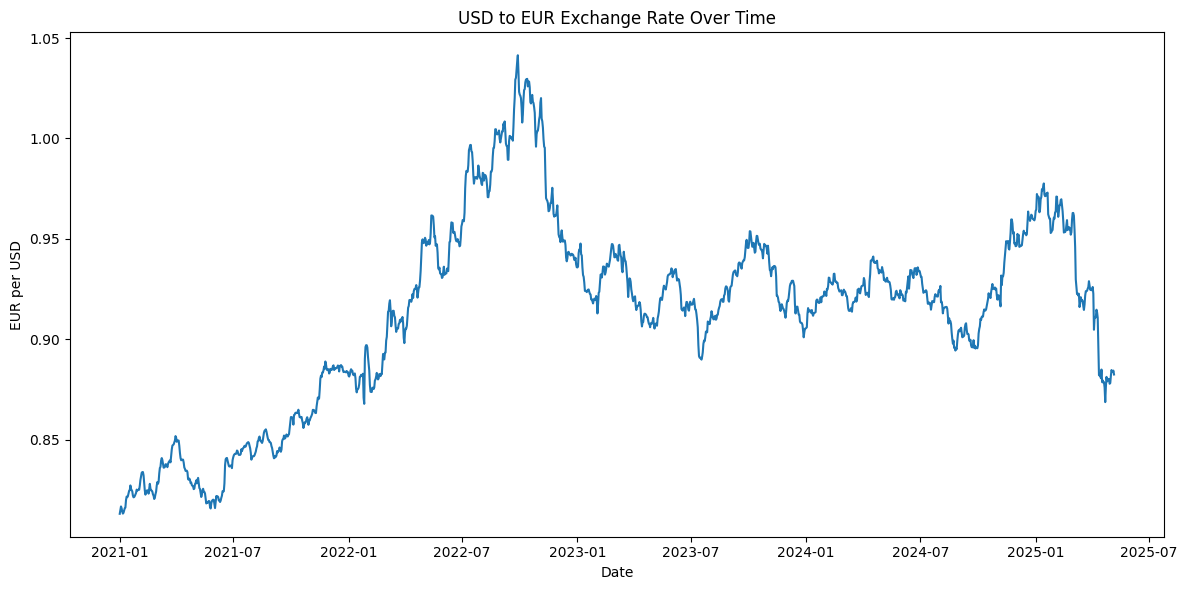

In [40]:
df_eur = df_all[df_all["Currency"] == "EUR"].copy()

df_eur["Date"] = pd.to_datetime(df_eur["Date"])

plt.figure(figsize = (12,6))
sns.lineplot(data=df_eur, x="Date", y="ExRate")
plt.title("USD to EUR Exchange Rate Over Time")
plt.ylabel("EUR per USD")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [45]:
#Creating Percent Change/Return Variables

df_all = df_all.sort_values(["Currency", "Date"])

df_all["DlyReturn"] = df_all.groupby("Currency")["ExRate"].pct_change()

df_all["DlyReturn"] *= 100

top5 = df_all.sort_values(by="DlyReturn", key=lambda x: x.abs(), ascending = False).head(5)

top5_down = df_all.sort_values(by="DlyReturn", ascending=True).head(5)

print(top5)
print(top5_down)

       Currency      ExRate        Date   DlyReturn
198657      ZWL     13.4097  2024-05-16         inf
185942      LBP  89500.0000  2024-02-28  496.666667
125030      LBP   8253.7500  2023-02-17  447.512438
229275      ZWL     25.2906  2024-11-21  378.562643
227979      ZWL     25.4834  2024-11-13  363.747702
       Currency     ExRate        Date   DlyReturn
198333      ZWL   0.000000  2024-05-14 -100.000000
45108       VES   4.159131  2021-10-09  -99.999593
192663      ZWL  13.561600  2024-04-09  -99.949731
228951      ZWL   5.284200  2024-11-19  -79.100286
227817      ZWL   5.495100  2024-11-12  -78.525790


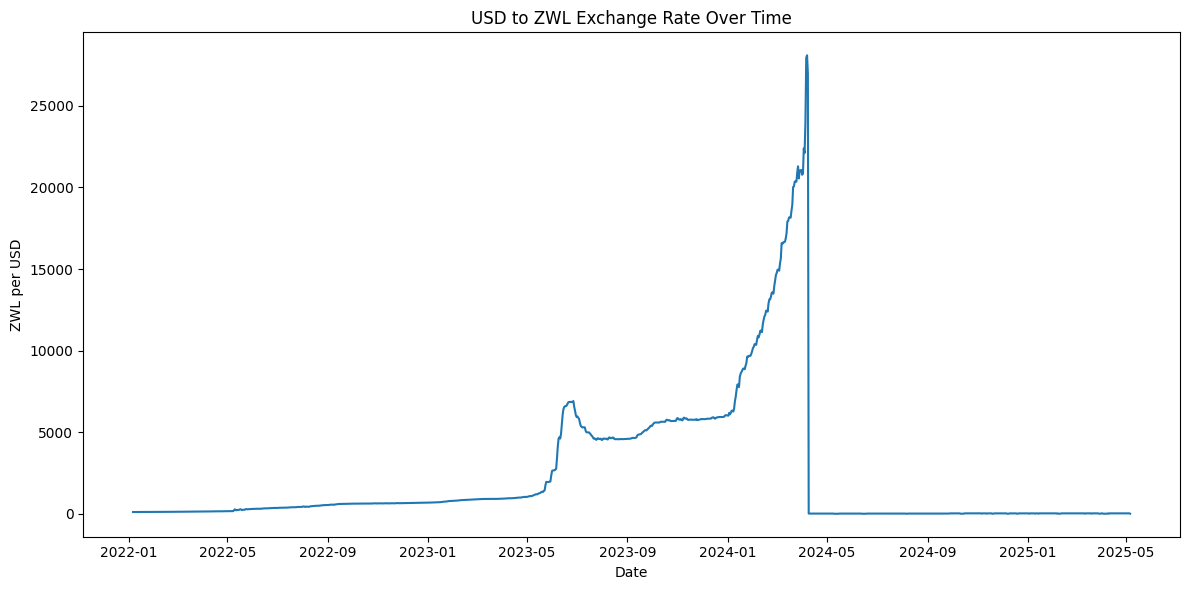

In [46]:
df_zwl = df_all[df_all["Currency"] == "ZWL"].copy()

df_zwl["Date"] = pd.to_datetime(df_zwl["Date"])

plt.figure(figsize = (12,6))
sns.lineplot(data=df_zwl, x="Date", y="ExRate")
plt.title("USD to ZWL Exchange Rate Over Time")
plt.ylabel("ZWL per USD")
plt.xlabel("Date")
plt.tight_layout()
plt.show()